['qVec', 'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 't0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 'samples0', 'samples1', 'samples2', 'samples3', 'samples4', 'samples5', 'samples6', 'samples7']
Timing :  28090337159358
Actual Charge :  3241
<class 'numpy.ndarray'>
(24,)
<TArrayS [13300, 13301, 13304, ..., 13299, 13301, 13303] at 0x77f2609aa740>
Calculated Charge :  -1.0648000000000002e-06
Sum :  -26518.0


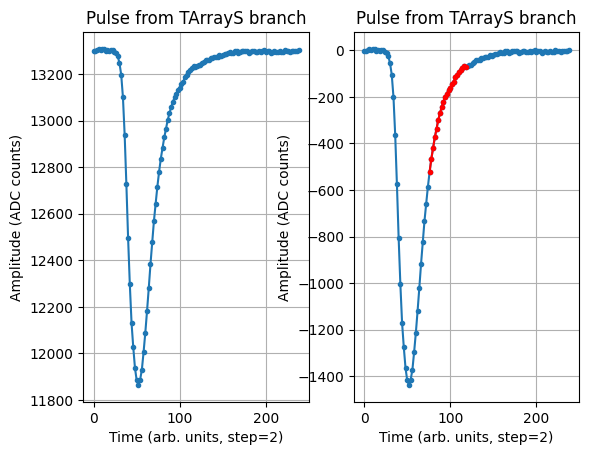

In [3]:
%run wavee.py

['qVec', 'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 't0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 'samples0', 'samples1', 'samples2', 'samples3', 'samples4', 'samples5', 'samples6', 'samples7']
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Mean of SampleRatio :  -0.5349048777198219
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Fit results: A=44.02, mu=-0.64, sigma=0.51
Fitted parameters: [  3.35871164 180.06055845   1.61112895   0.51653381  17.39031249
   0.3896032 ]
1949.7875457875457
3196.252747252747
Mean of Ratio 13:  1.0298963893895348
['qVec', 'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 't0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 'samples0', 'samples1', 'samples2', 'samples3', 'samples4', 'samples5', 'samples6', 'samples7']
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Mean of SampleRatio :  -0.40112855088423477
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Fit results: A=97.38, mu=-0.48, sigma=0.38
Fitted parameters: [  3.35871164 180.06055845   1.61112895   0.51653381  17.39031249
 

<Figure size 800x800 with 0 Axes>

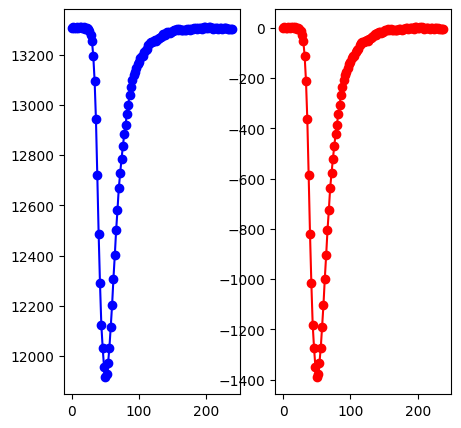

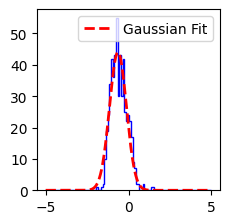

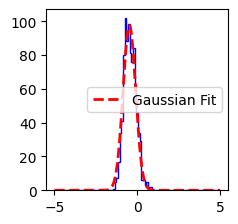

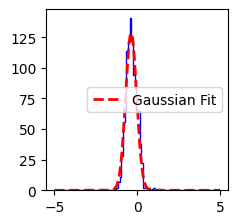

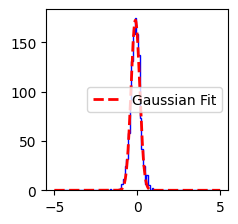

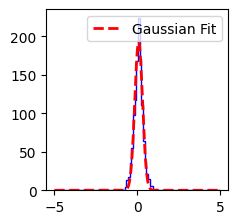

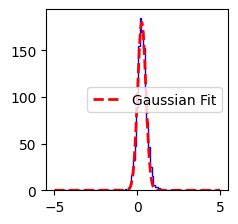

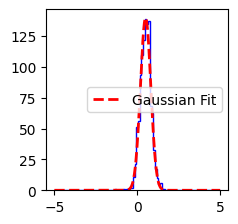

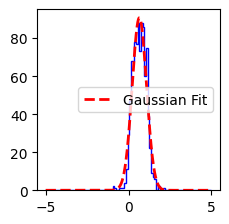

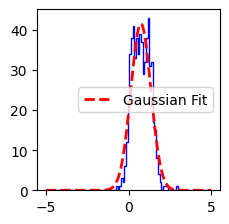

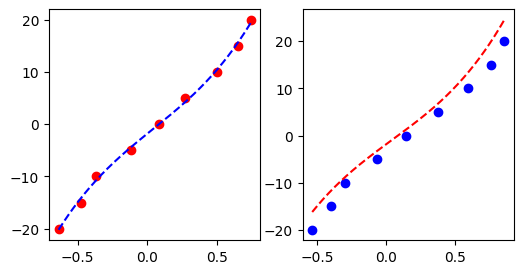

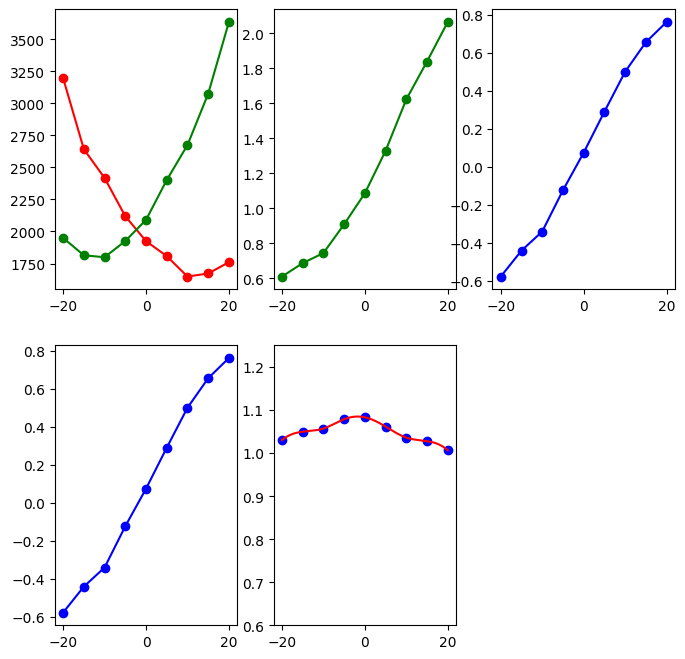

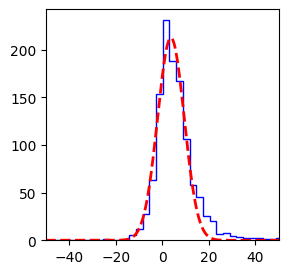

In [108]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import make_interp_spline
from scipy.optimize import curve_fit
import ROOT
from colorama import Fore, Style, init
init(autoreset=True)

import numpy as np

def baseline_subtract(pulse, n_baseline=16):
    """
    Subtracts baseline from a pulse.
    n_baseline: number of samples at start used to estimate baseline
    """
    baseline = np.median(pulse[:n_baseline])
    return pulse - baseline
    
def gaussian(x, amplitude, mean, sigma):
    return amplitude * np.exp(-(x - mean)**2 / (2 * sigma**2))
    
def crystalball(x, alpha, n, mean, sigma, N):
    # (N = normalization)
    z = (x - mean) / sigma
    if isinstance(z, np.ndarray):
        result = np.zeros_like(z)
    else:
        result = 0

    # Transition point
    mask = z > -alpha

    # Gaussian region
    result[mask] = N * np.exp(-0.5 * z[mask]**2)

    # Power-law tail region
    A = (n / abs(alpha))**n * np.exp(-0.5 * alpha**2)
    B = n / abs(alpha) - abs(alpha)
    result[~mask] = N * A * (B - z[~mask])**(-n)

    return result

def cb_plus_const(x, alpha, n, mu, sigma, N, C):
    return crystalball(x, alpha, n, mu, sigma, N) + C

base_path="/home/rsehgal/shared/SquareScint/CPP/build/"


#file_list=["Muon_output_-10_-20.root","Muon_output_-10_-10.root","Muon_output_-10_0.root","Muon_output_-10_10.root","Muon_output_-10_20.root"]
#loc_list = [-20,-10,0,10,20]

file_list=["Muon_output_0_-20.root","Muon_output_0_-15.root","Muon_output_0_-10.root","Muon_output_0_-5.root","Muon_output_0_0.root","Muon_output_0_5.root","Muon_output_0_10.root","Muon_output_0_15.root","Muon_output_0_20.root"]
loc_list = [-20,-15,-10,-5,0,5,10,15,20]

#file_list=["Muon_output_10_-20.root","Muon_output_10_-15.root","Muon_output_10_-10.root","Muon_output_10_-5.root","Muon_output_10_0.root","Muon_output_10_5.root","Muon_output_10_10.root","Muon_output_10_15.root","Muon_output_10_20.root"]
#loc_list = [-20,-15,-10,-5,0,5,10,15,20]

#file_list=["Muon_output_20_-20.root","Muon_output_20_-10.root","Muon_output_20_0.root","Muon_output_20_10.root","Muon_output_20_20.root"]
#loc_list = [-20,-10,0,10,20]

#file_list=["Muon_output_-20_-20.root","Muon_output_-20_-10.root","Muon_output_-20_0.root","Muon_output_-20_10.root","Muon_output_-20_20.root"]
#loc_list = [-20,-10,0,10,20]

mean_list_q0=[]
mean_list_q2=[]
ratio=[]
ratio_log=[]
mean_ratio_1_3=[]
actualLogRatioList=[]

plt.figure(figsize=(8,8))
counter = 1

binss=np.linspace(-5,5,100)

chargeMean=[]

pulseLength=120
xval = np.arange(pulseLength) * 2
#print(xval)
sampleRatioMeanList=[]
for filename in file_list:

    file = uproot.open(base_path+filename)
    sampleRatio=[]
    
    # check the tree
    tree = file["treeML"]
    
    print(tree.keys())
    ratio_list=[]
    delt_list=[]
    ratio_log_list=[]
    ratio_list_1_3=[]
    
    q0 = tree["q0"].array(library="np")
    treeData = tree.arrays(["t0","t2","q0","q1","q2","q3","samples0","samples2"],library="np")
    #timing0 = tree["t0"].array(library="np")
    mean_list_q0.append(np.mean(treeData["q0"]))
    mean_list_q2.append(np.mean(treeData["q2"]))

    pulse0=treeData["samples0"]
    pulse2=treeData["samples2"]
    rawPulse=pulse0[0]
    bs_pulse=baseline_subtract(rawPulse)

    #Just to see the RAW and BACKGROUND_SUBTRACTED pulse
    if counter==1:
        plt.figure(figsize=(5,5))
        plt.subplot(1,2,1)
        plt.plot(xval,rawPulse,marker="o",color="blue")
        plt.subplot(1,2,2)
        plt.plot(xval,bs_pulse,marker="o",color="red")

    for i in range(len(pulse0)):
        sampleRatio.append(math.log(np.min(baseline_subtract(pulse2[i]))/np.min(baseline_subtract(pulse0[i]))))

    #if counter==7:
    #    actualLogRatioList = sampleRatio
        
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    print("Mean of SampleRatio : ",np.mean(sampleRatio))
    sampleRatioMeanList.append(np.mean(sampleRatio))
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    
    '''    
    print("PULSE LENGTH : ",len(pulse0[0]))
    print("Max value 0: ",np.min(baseline_subtract(pulse0[0])))
    print("Max value 2: ",np.min(baseline_subtract(pulse2[0])))
    print(Fore.RED + "Ratio of Max Samples : ",np.min(baseline_subtract(pulse0[0]))/np.min(baseline_subtract(pulse2[0])))
    '''

    for i in range(len(treeData["q0"])):
        ratio_list.append(math.log(treeData["q2"][i]/treeData["q0"][i]))
        ratio_log_list.append(math.log(treeData["q2"][i]/treeData["q0"][i]))
        ratio_list_1_3.append(treeData["q3"][i]/treeData["q1"][i])
        #if math.floor(len(loc_list)/2)==counter-1 : 
        if counter==6:    
            actualLogRatioList = ratio_list
            
    plt.figure(figsize=(8,8))
    plt.subplot(3,3,counter)
    counts, bins, _ =plt.hist(ratio_list,bins=binss,histtype='step',color='blue')
    #p0 = [1.5, 3, 1.5, 1.0, 100]  # initial guesses
    #popt, pcov = curve_fit(crystal_ball, binss, ratio_list, p0=p0)
    '''
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    # Initial guess (alpha, n, mean, sigma, N)
    p0 = [3.5, 3, np.mean(ratio_list), np.std(ratio_list)+0.6, 100]
    # Fit
    params, cov = curve_fit(crystalball, bin_centers, counts, p0=p0)
    # Plot fit
    x_fit = np.linspace(min(ratio_list), max(ratio_list), 500)
    y_fit = crystalball(x_fit, *params)
    '''
    '''
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    sigma_counts = np.sqrt(np.clip(counts, 1, None))  # Poisson errors
    p0 = [1.5, 4.0, bin_centers[np.argmax(counts)], np.std(ratio_list), counts.max(), 0.0]
    bounds = ([0.3, 1.0, bin_centers.min(), 1e-6, 0, 0],
          [6.0, 200.0, bin_centers.max(), (bins[-1]-bins[0]), 1e9, counts.max()])

    params, cov = curve_fit(cb_plus_const, bin_centers, counts, p0=p0,
                        sigma=sigma_counts, absolute_sigma=True,
                        bounds=bounds, maxfev=40000)

    x_fit = np.linspace(min(ratio_list), max(ratio_list), 500)
    y_fit = cb_plus_const(x_fit, *params)
    
    plt.plot(x_fit, y_fit, 'r-', label="Crystal Ball fit")
    '''

    #For Gaussian
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Initial guess for fit parameters: A, mean, sigma
    p0 = [max(counts), np.mean(ratio_list), np.std(ratio_list)]
    # Fit using curve_fit
    popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=p0)
    # Extract fit results
    A_fit, mu_fit, sigma_fit = popt
    print(f"Fit results: A={A_fit:.2f}, mu={mu_fit:.2f}, sigma={sigma_fit:.2f}")
    chargeMean.append(mu_fit);

    
    # Plot fitted Gaussian
    x_fit = np.linspace(min(bins), max(bins), 1000)
    y_fit = gaussian(x_fit, *popt)
    plt.plot(x_fit, y_fit, 'r--', linewidth=2, label='Gaussian Fit')
    
    plt.legend()
    #plt.show()

    print("Fitted parameters:", params)
    counter += 1
    
    ratio.append(np.mean(ratio_list))    
    mean_ratio_1_3.append(np.mean(ratio_list_1_3))
    ratio_log.append(np.mean(ratio_log_list))
    
    print(np.mean(treeData["q2"]))
    print(np.mean(treeData["q0"]))
    #print("Ratio of Mean : ",np.mean(treeData["q2"])/np.mean(treeData["q0"]))
    #print("Mean of Ratio : ",np.mean(ratio_list))
    print("Mean of Ratio 13: ",np.mean(ratio_list_1_3))
    #print("Hello : ",len(treeData["q0"]))
    
    print("================================")

#For Parameterization
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(chargeMean,loc_list,"o",color="red")
#Fitting 3rd order polynomial
coeffs = np.polyfit(chargeMean, loc_list, 3)  # degree = 3
poly = np.poly1d(coeffs)

evaluatedResult=poly(actualLogRatioList)
# Generate smooth curve for plotting
x_fit = np.linspace(min(chargeMean), max(chargeMean), 500)
y_fit = poly(x_fit)
plt.plot(x_fit, y_fit, 'b--', label="3rd Order Fit")

plt.subplot(1,2,2)
plt.plot(sampleRatioMeanList,loc_list,"o", color="blue")
coeffs_sample = np.polyfit(sampleRatioMeanList, loc_list, 3)  # degree = 3
poly_sample = np.poly1d(coeffs_sample)
#evaluatedResult=poly_sample(actualLogRatioList)
# Generate smooth curve for plotting
x_fit = np.linspace(min(sampleRatioMeanList), max(sampleRatioMeanList), 500)
y_fit = poly(x_fit)
plt.plot(x_fit, y_fit, 'r--', label="3rd Order Fit")


plt.figure(figsize=(8,8))
plt.subplot(2,3,1)
plt.plot(loc_list,mean_list_q0,marker="o",color="red")
plt.subplot(2,3,1)
plt.plot(loc_list,mean_list_q2,marker="o",color="green")

ratio_mean_list=[]
for i in range(len(mean_list_q0)):
    ratio_mean_list.append(mean_list_q2[i]/mean_list_q0[i])

x_smooth = np.linspace(min(loc_list), max(loc_list), 300)
# Spline interpolation
spline = make_interp_spline(loc_list, mean_ratio_1_3, k=3)  # k=3 → cubic spline
y_smooth = spline(x_smooth)

plt.subplot(2,3,2)
plt.plot(loc_list,ratio_mean_list,marker="o",color="green")
plt.subplot(2,3,3)
plt.plot(loc_list,ratio,marker="o",color="blue")
plt.subplot(2,3,4)
plt.plot(loc_list,ratio_log,marker="o",color="blue")
plt.subplot(2,3,5)
plt.plot(loc_list,mean_ratio_1_3,"o",color="blue")
plt.plot(x_smooth, y_smooth, "-", color='red',label="Smooth Curve")
plt.ylim(0.6, 1.25)

plt.figure(figsize=(3,3))
#binss = np.linspace(-25,25,100)
#print(evaluatedResult)

print("Mean of Result : ",np.mean(evaluatedResult))
print("Sigma of Result : ",np.std(evaluatedResult))

counts, bins, _ =plt.hist(evaluatedResult,histtype="step",bins=50,color="blue")
plt.xlim(-50,50)
#For Gaussian
bin_centers = 0.5 * (bins[1:] + bins[:-1])
# Initial guess for fit parameters: A, mean, sigma
p0 = [max(counts), np.mean(evaluatedResult), np.std(evaluatedResult)]
# Fit using curve_fit
popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=p0)
# Extract fit results
A_fit, mu_fit, sigma_fit = popt
# Plot fitted Gaussian
x_fit = np.linspace(min(bins), max(bins), 1000)
y_fit = gaussian(x_fit, *popt)
plt.plot(x_fit, y_fit, 'r--', linewidth=2, label='Gaussian Fit')
print(f"Fit results: A={A_fit:.2f}, mu={mu_fit:.2f}, sigma={sigma_fit:.2f}")

plt.show()